# Evaluation

How often do regular differential expression analysis vs sophie prioritize the specific vs generic genes?

1. Simulate 1 template perturbation experiment using the technique above
2. Apply SOPHIE to get ranking of specific and generic genes based on their z-score.
3. Apply traditional DE analysis and get ranking of specific and generic genes based on their log fold change value
4. Compare the difference in ranking between specific and generic genes using SOPHIE vs traditional metrics.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
import os
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects import pandas2ri
from ponyo import utils, train_vae_modules, simulate_expression_data
from generic_expression_patterns_modules import (
    process,
    new_experiment_process,  # REMOVE
    stats,
    ranking,
)

np.random.seed(1)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = "config_sophie_vs_trad.tsv"

params = utils.read_config(config_filename)

In [3]:
# Load config params

# Local directory to store intermediate files
local_dir = params["local_dir"]

#
dataset_name = params["dataset_name"]

# File containing un-normalized template experiment
raw_template_filename = params["raw_template_filename"]

# Un-normalized compendium filename
raw_compendium_filename = params["raw_compendium_filename"]

# Normalized compendium filename
normalized_compendium_filename = params["normalized_compendium_filename"]

# ID for template experiment to be selected
project_id = params["project_id"]

# Number of simulated experiments to generate
num_runs = params["num_simulated"]

# Directory containing trained VAE model
vae_model_dir = params["vae_model_dir"]

# Size of the latent dimension
latent_dim = params["latent_dim"]

# Scaler transform used to scale compendium data into 0-1 range for training
scaler_filename = params["scaler_filename"]

# Which DE method to use
# We recommend that if data is RNA-seq then use DESeq2
# If data is microarray then use Limma
de_method = params["DE_method"]

# If using DE-seq, setting this parameter will
# remove genes below a certain threshold
count_threshold = params["count_threshold"]

# Metadata file that specifies which samples to keep for DE analysis (Optional)
template_process_samples_filename = params["template_process_samples_filename"]

# Metadata file that specifies sample grouping for DE analysis
template_DE_grouping_filename = params["template_DE_grouping_filename"]

# Statistic to use to rank genes or pathways by
# Choices are {} FILL IN
col_to_rank_genes = params["rank_genes_by"]

# Pickle files saving specific and generic gene ids
template_specific_gene_ids_filename = params["template_specific_gene_ids_filename"]
generic_gene_ids_filename = "generic_gene_ids.pickle"

In [4]:
# Files generated by this notebook

# File storing template experiment with gene ids mapped to compendium gene ids
mapped_template_filename = params["mapped_template_filename"]

# File storing normalized template experiment
normalized_template_filename = params["normalized_template_filename"]

# File storing processed template experiment,
# after samples have been selected for comparison in DE analysis
processed_template_filename = params["processed_template_filename"]

# Output summary file
output_filename = params["output_filename"]

## SOPHIE

In [5]:
# Normalize compendium
process.normalize_compendium(
    raw_compendium_filename,
    normalized_compendium_filename,
    scaler_filename,
)

input: dataset contains 360 samples and 1000 genes


In [6]:
# Create VAE directories if needed
output_dirs = [
    os.path.join(base_dir, dataset_name, "models"),
    os.path.join(base_dir, dataset_name, "logs"),
]

NN_architecture = params["NN_architecture"]

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    sub_dir = os.path.join(each_dir, NN_architecture)
    os.makedirs(sub_dir, exist_ok=True)

input dataset contains 360 samples and 1000 genes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))



Train on 324 samples, validate on 36 samples
Epoch 1/10
324/324 [==============================] - 1s 4ms/step - loss: 226.0067 - val_loss: 187.7223
Epoch 2/10
324/324 [==============================] - 1s 2ms/step - loss: 117.0900 - val_loss: 386.9967
Epoch 3/10
324/324 [==============================] - 1s 2ms/step - loss: 109.1484 - val_loss: 264.3614
Epoch 4/10
324/324 [==============================] - 1s 2ms/step - loss: 101.9352 - val_loss: 197.6296
Epoch 5/10
324/324 [==============================] - 1s 2ms/step - loss: 111.3432 - val_loss: 150.0069
Epoch 6/10
324/324 [==============================] - 1s 2ms/step - loss: 101.8399 - val_loss: 310.7296
Epoch 7/10
324/324 [==============================] - 1s 2ms/step - loss: 95.6762 - val_loss: 118.6455
Epoch 8/10
324/324 [==============================] - 1s 2ms/step - loss: 98.7335 - val_loss: 124.8610
Epoch 9/10
324/324 [==============================] - 1s 2ms/step - loss: 116.0227 - val_loss: 146.9694
Epoch 10/10
324/324 

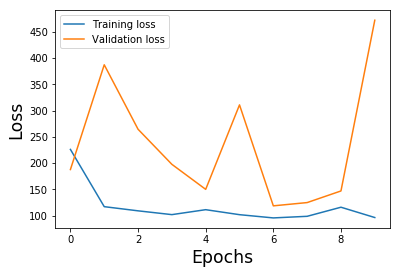

In [7]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_filename, normalized_compendium_filename)